In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from tqdm import tqdm
from transformers import BertTokenizer
from gensim.models import KeyedVectors
from datasets import load_dataset
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import gensim.downloader as api

## dataset

In [3]:
# Load AG News Dataset
dataset = load_dataset('ag_news')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize(text):
    return tokenizer(text, padding='max_length', truncation=True, return_tensors='pt', max_length=128)

# Load Word2Vec Embeddings
word2vec = api.load('word2vec-google-news-300')

def get_word2vec_embedding(tokens):
    embeddings = []
    for token in tokens:
        if token in word2vec:
            embeddings.append(word2vec[token])
    if len(embeddings) == 0:
        return np.zeros(word2vec.vector_size)
    return np.mean(embeddings, axis=0)

class AGNewsDataset(data.Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        tokens = tokenizer.tokenize(self.texts[idx])
        embedding = get_word2vec_embedding(tokens)
        label = self.labels[idx]
        return torch.tensor(embedding, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

train_texts = [item['text'] for item in dataset['train']]
train_labels = [item['label'] for item in dataset['train']]
test_texts = [item['text'] for item in dataset['test']]
test_labels = [item['label'] for item in dataset['test']]

train_dataset = AGNewsDataset(train_texts, train_labels)
test_dataset = AGNewsDataset(test_texts, test_labels)

train_loader = data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=64, shuffle=False)


In [ ]:
train_emb = [get_word2vec_embedding(tokenizer.tokenize(item['text'])) for item in dataset['train']]

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
emb_all = torch.Tensor(np.array(train_emb)).to(device)

In [ ]:
train_emb

In [ ]:
train_emb[0].shape

In [ ]:
train_dataset[0][0].shape

In [ ]:
import pandas as pd
pd.Series(train_labels).value_counts()

## Model

In [ ]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 100, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(100 * (word2vec.vector_size // 2), 4)  # 4 classes in AG News

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

## Util functions

In [ ]:
from torch.utils.data import Dataset
class TensorDataset(Dataset):
    def __init__(self, images, labels): # images: n x c x h x w tensor
        self.images = images.detach().float()
        self.labels = labels.detach()

    def __getitem__(self, index):
        return self.images[index], self.labels[index]

    def __len__(self):
        return self.images.shape[0]


In [ ]:

def distance_wb(gwr, gws):
    shape = gwr.shape
    if len(shape) == 4: # conv, out*in*h*w
        gwr = gwr.reshape(shape[0], shape[1] * shape[2] * shape[3])
        gws = gws.reshape(shape[0], shape[1] * shape[2] * shape[3])
    elif len(shape) == 3:  # layernorm, C*h*w
        gwr = gwr.reshape(shape[0], shape[1] * shape[2])
        gws = gws.reshape(shape[0], shape[1] * shape[2])
    elif len(shape) == 2: # linear, out*in
        tmp = 'do nothing'
    elif len(shape) == 1: # batchnorm/instancenorm, C; groupnorm x, bias
        gwr = gwr.reshape(1, shape[0])
        gws = gws.reshape(1, shape[0])
        return torch.tensor(0, dtype=torch.float, device=gwr.device)

    dis_weight = torch.sum(1 - torch.sum(gwr * gws, dim=-1) / (torch.norm(gwr, dim=-1) * torch.norm(gws, dim=-1) + 0.000001))
    dis = dis_weight
    return dis


def match_loss(gw_syn, gw_real, dis_metric):
    dis = torch.tensor(0.0).to(device)

    if dis_metric == 'ours':
        for ig in range(len(gw_real)):
            gwr = gw_real[ig]
            gws = gw_syn[ig]
            dis += distance_wb(gwr, gws)

    elif dis_metric == 'mse':
        gw_real_vec = []
        gw_syn_vec = []
        for ig in range(len(gw_real)):
            gw_real_vec.append(gw_real[ig].reshape((-1)))
            gw_syn_vec.append(gw_syn[ig].reshape((-1)))
        gw_real_vec = torch.cat(gw_real_vec, dim=0)
        gw_syn_vec = torch.cat(gw_syn_vec, dim=0)
        dis = torch.sum((gw_syn_vec - gw_real_vec)**2)

    elif dis_metric == 'cos':
        gw_real_vec = []
        gw_syn_vec = []
        for ig in range(len(gw_real)):
            gw_real_vec.append(gw_real[ig].reshape((-1)))
            gw_syn_vec.append(gw_syn[ig].reshape((-1)))
        gw_real_vec = torch.cat(gw_real_vec, dim=0)
        gw_syn_vec = torch.cat(gw_syn_vec, dim=0)
        dis = 1 - torch.sum(gw_real_vec * gw_syn_vec, dim=-1) / (torch.norm(gw_real_vec, dim=-1) * torch.norm(gw_syn_vec, dim=-1) + 0.000001)

    else:
        exit('unknown distance function: %s'%args.dis_metric)

    return dis

In [ ]:
def epoch(mode, dataloader, net, optimizer, criterion):
    loss_avg, acc_avg, num_exp = 0, 0, 0
    net = net.to(device)
    criterion = criterion.to(device)

    if mode == 'train':
        net.train()
    else:
        net.eval()

    for i_batch, datum in enumerate(dataloader):
        sample = datum[0].float().to(device)
        
        lab = datum[1].long().to(device)
        n_b = lab.shape[0]

        output = net(sample)
        loss = criterion(output, lab)
        acc = np.sum(np.equal(np.argmax(output.cpu().data.numpy(), axis=-1), lab.cpu().data.numpy()))

        loss_avg += loss.item()*n_b
        acc_avg += acc
        num_exp += n_b

        if mode == 'train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    loss_avg /= num_exp
    acc_avg /= num_exp

    return loss_avg, acc_avg

In [ ]:
import pickle
def evaluate_syn(model, synthetic_text_data, synthetic_labels, test_loader, device, num_epochs=10, lr=0.001):
    # Define criterion and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer_net = optim.Adam(model.parameters(), lr=lr)

    # Create DataLoader for synthetic data
    synthetic_dataset = data.TensorDataset(synthetic_text_data.detach(), synthetic_labels)
    synthetic_loader = data.DataLoader(synthetic_dataset, batch_size=64, shuffle=True)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        for inputs, labels in tqdm(synthetic_loader, desc=f'Training Epoch {epoch+1}/{num_epochs}', unit='batch'):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer_net.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer_net.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        if epoch % 9 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')

    # Final evaluation on test set
    model.eval()
    test_labels = []
    test_preds = []
    with torch.no_grad():
        for texts, labels in tqdm(test_loader, desc='Evaluating on test set', unit='batch'):
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            _, preds = torch.max(outputs, 1)
            test_labels.extend(labels.cpu().numpy())
            test_preds.extend(preds.cpu().numpy())

    overall_accuracy = accuracy_score(test_labels, test_preds)
    class_report = classification_report(test_labels, test_preds, target_names=['0','1','2','3'])

    print(f'Test Accuracy: {overall_accuracy:.4f}')
    print('Classification Report:')
    print(class_report)

    # Save results to a pickle file
    results = {
        'test_accuracy': overall_accuracy,
        'classification_report': class_report
    }
    with open('results1.pkl', 'wb') as f:
        pickle.dump(results, f)

    #print(test_labels, test_preds)
    return overall_accuracy

## Loops

### hyperparameters

In [ ]:
n_experiments = 1
num_classes = len(pd.Series(train_labels).unique())
n_spc = 200 # samples_per_class
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_iterations = 1000

batch_train = 256
batch_real = 256
batch_syn = 256

n_outer_loop = 50
n_inner_loop = 10

num_eval_epochs = 20

In [16]:
print(num_classes)

4


In [ ]:
indices_class = [[] for _ in range(num_classes)]

# Populate indices_class with indices of embeddings for each class
for i, lab in enumerate(train_labels):
    indices_class[lab].append(i)

for c in range(num_classes):
            print('class c = %d: %d real images'%(c, len(indices_class[c])))

In [ ]:
def get_embs(c, n):
    # Get random n embeddings from class c
    idx_shuffle = np.random.permutation(indices_class[c])[:n]
    return  emb_all[idx_shuffle]  # [emb_all[i] for i in idx_shuffle]

In [ ]:
### Loop understanding ###

'''
n_exps = 1
iterations = 1000
n_outer_loop = 5
n_inner_loop = 5
batch_size  = 256

for exp in n_exps:

    initialize synthetic data
    initialize sytnethic_optimizer

    for it in range(iterations):

        initialize model
        initialize model optimizer

        train_and_evaluate_on_test model on synthetic data
     
        for ol in n_outer_loops:

            for c in range(num_classes):

                pass batch of real-data through model

                pass synthetic data through model 

                obtain gw_real and gw_syn (gradients)

                calculate matching loss between gradients

            sytnethic_optimizer.step()

            for il in n_inner_loop:
                update model with synthetic_data

'''

In [ ]:
from tqdm import tqdm
import copy

data_save = []
accs_hist = []
for exp_n in range(n_experiments):
    print('\n================== Exp %d ==================\n '%exp_n)

    ''' initialize the synthetic data '''
    synthetic_text_data = torch.randn(num_classes * n_spc, word2vec.vector_size, requires_grad=True)
    synthetic_labels = torch.tensor([i for i in range(num_classes) for _ in range(n_spc)], dtype=torch.long).to(device)

    optimizer_syn = optim.SGD([synthetic_text_data], lr=0.01, momentum=0.9)

    optimizer_syn.zero_grad()
    criterion = nn.CrossEntropyLoss().to(device)
    
    print('%s training begins')


    
    for it in range(n_iterations+1):
        
        ''' Train synthetic data '''
        model = CNNModel().to(device)
        model.train()
        model_parameters = list(model.parameters())

        optimizer_net = optim.SGD(model.parameters(), lr=0.01)
        optimizer_net.zero_grad()

        loss_avg = 0

        accs_hist.append(evaluate_syn(model, synthetic_text_data, synthetic_labels, test_loader, device, num_epochs=10, lr=0.001))


        ''' Outer Loops '''

        for ol in tqdm(range(n_outer_loop)):
            print('starting outer loop')
            
            loss = torch.tensor(0.0).to(device)
            
            for c in range(num_classes):
    
                text_real = get_embs(c, batch_real)
                lab_real = torch.ones((text_real.shape[0],), device=device, dtype=torch.long) * c
    
                text_syn = synthetic_text_data[c*n_spc:(c+1)*n_spc].to(device)
                lab_syn = torch.ones((n_spc,), device=device, dtype=torch.long) * c
    
                output_real = model(text_real)
                loss_real = criterion(output_real, lab_real)
    
                gw_real = torch.autograd.grad(loss_real, model_parameters)
                gw_real = list((_.detach().clone() for _ in gw_real))
    
                output_syn = model(text_syn)
                loss_syn = criterion(output_syn, lab_syn)
                
                gw_syn = torch.autograd.grad(loss_syn, model_parameters, create_graph=True)
    
                loss += match_loss(gw_syn, gw_real, 'ours')

            optimizer_syn.zero_grad()
            loss.backward()
            optimizer_syn.step()
            loss_avg += loss.item()

            ''' update network '''

            text_syn_train, label_syn_train = copy.deepcopy(text_syn.detach()), copy.deepcopy(lab_syn.detach())
            dst_syn_train = TensorDataset(text_syn_train, label_syn_train)
            trainloader = torch.utils.data.DataLoader(dst_syn_train, batch_size=batch_train, shuffle=True, num_workers=0)
               
            for il in tqdm(range(n_inner_loop)):
                epoch('train', trainloader, model, optimizer_net, criterion)


        loss_avg /= (num_classes*n_outer_loop)

        if it%10 == 0:
            print(' iter = %04d, loss = %.4f' % (it, loss_avg))

# only record the final results
data_save.append([copy.deepcopy(synthetic_text_data.detach().cpu()), copy.deepcopy(synthetic_labels.detach().cpu())])
torch.save({'data': data_save}, 'results_50ol10il_200spc.pth')

In [ ]:
with open('accs_hist_50ol10il_200spc.pkl', 'wb') as f:
    pickle.dump(accs_hist, f)

In [23]:
accs_hist

[0.25,
 0.25,
 0.25,
 0.25,
 0.2507894736842105,
 0.2501315789473684,
 0.27723684210526317,
 0.24960526315789475,
 0.25,
 0.25,
 0.25,
 0.25,
 0.24986842105263157,
 0.25,
 0.2356578947368421,
 0.24986842105263157,
 0.25,
 0.24986842105263157,
 0.2388157894736842,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.24223684210526317,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,


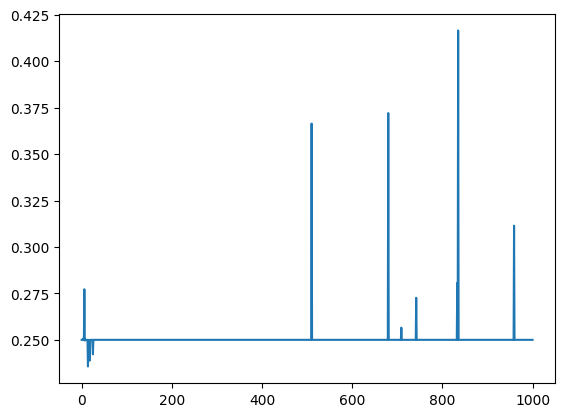

In [24]:
import matplotlib.pyplot as plt
plt.plot(accs_hist)

In [25]:
model = CNNModel().to(device)
evaluate_syn(model, synthetic_text_data, synthetic_labels, test_loader, device, num_epochs=200, lr=0.001)

Training Epoch 1/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 219.40batch/s]


Epoch [1/200], Train Loss: 13.8395, Train Accuracy: 66.88%


Training Epoch 10/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 298.58batch/s]


Epoch [10/200], Train Loss: 0.9715, Train Accuracy: 98.25%


Training Epoch 19/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 302.45batch/s]


Epoch [19/200], Train Loss: 0.5833, Train Accuracy: 98.75%


Training Epoch 28/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 300.61batch/s]


Epoch [28/200], Train Loss: 0.4708, Train Accuracy: 98.62%


Training Epoch 37/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 305.42batch/s]


Epoch [37/200], Train Loss: 0.2571, Train Accuracy: 99.12%


Training Epoch 46/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 303.98batch/s]


Epoch [46/200], Train Loss: 0.1852, Train Accuracy: 99.25%


Training Epoch 55/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 305.61batch/s]


Epoch [55/200], Train Loss: 0.1577, Train Accuracy: 99.25%


Training Epoch 64/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 305.20batch/s]


Epoch [64/200], Train Loss: 0.1363, Train Accuracy: 99.25%


Training Epoch 73/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 305.70batch/s]


Epoch [73/200], Train Loss: 0.1408, Train Accuracy: 99.50%


Training Epoch 82/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 298.85batch/s]


Epoch [82/200], Train Loss: 0.1340, Train Accuracy: 99.38%


Training Epoch 91/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 304.19batch/s]


Epoch [91/200], Train Loss: 0.1073, Train Accuracy: 99.75%


Training Epoch 100/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 307.85batch/s]


Epoch [100/200], Train Loss: 0.1422, Train Accuracy: 99.50%


Training Epoch 109/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 305.07batch/s]


Epoch [109/200], Train Loss: 0.1032, Train Accuracy: 99.50%


Training Epoch 118/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 301.61batch/s]


Epoch [118/200], Train Loss: 0.0883, Train Accuracy: 99.75%


Training Epoch 127/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 307.63batch/s]


Epoch [127/200], Train Loss: 0.0936, Train Accuracy: 99.50%


Training Epoch 136/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 304.89batch/s]


Epoch [136/200], Train Loss: 0.0717, Train Accuracy: 100.00%


Training Epoch 145/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 313.35batch/s]


Epoch [145/200], Train Loss: 0.0628, Train Accuracy: 100.00%


Training Epoch 154/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 314.23batch/s]


Epoch [154/200], Train Loss: 0.0692, Train Accuracy: 99.75%


Training Epoch 163/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 319.67batch/s]


Epoch [163/200], Train Loss: 0.0895, Train Accuracy: 99.62%


Training Epoch 172/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 328.17batch/s]


Epoch [172/200], Train Loss: 0.0650, Train Accuracy: 99.88%


Training Epoch 181/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 325.11batch/s]


Epoch [181/200], Train Loss: 0.0461, Train Accuracy: 100.00%


Training Epoch 190/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 304.76batch/s]


Epoch [190/200], Train Loss: 0.0493, Train Accuracy: 100.00%


Training Epoch 199/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 311.35batch/s]


Epoch [199/200], Train Loss: 0.0435, Train Accuracy: 99.75%


Evaluating on test set: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 15.45batch/s]

Test Accuracy: 0.2500
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1900
           1       0.00      0.00      0.00      1900
           2       0.25      1.00      0.40      1900
           3       0.00      0.00      0.00      1900

    accuracy                           0.25      7600
   macro avg       0.06      0.25      0.10      7600
weighted avg       0.06      0.25      0.10      7600




/home/IAIS/rrao/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/IAIS/rrao/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/IAIS/rrao/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.25

In [38]:
model = CNNModel().to(device)
evaluate_syn(model, synthetic_text_data, synthetic_labels, test_loader, device, num_epochs=200, lr=0.001)

Training Epoch 1/200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 226.36batch/s]


Epoch [1/200], Train Loss: 43.3000, Train Accuracy: 23.12%


Training Epoch 10/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 307.51batch/s]


Epoch [10/200], Train Loss: 2.2411, Train Accuracy: 97.12%


Training Epoch 19/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 304.11batch/s]


Epoch [19/200], Train Loss: 0.5581, Train Accuracy: 100.00%


Training Epoch 28/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 312.56batch/s]


Epoch [28/200], Train Loss: 0.2387, Train Accuracy: 100.00%


Training Epoch 37/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 315.44batch/s]


Epoch [37/200], Train Loss: 0.1306, Train Accuracy: 100.00%


Training Epoch 46/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 321.95batch/s]


Epoch [46/200], Train Loss: 0.0831, Train Accuracy: 100.00%


Training Epoch 55/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 305.66batch/s]


Epoch [55/200], Train Loss: 0.0581, Train Accuracy: 100.00%


Training Epoch 64/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 313.12batch/s]


Epoch [64/200], Train Loss: 0.0427, Train Accuracy: 100.00%


Training Epoch 73/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 317.97batch/s]


Epoch [73/200], Train Loss: 0.0317, Train Accuracy: 100.00%


Training Epoch 82/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 310.90batch/s]


Epoch [82/200], Train Loss: 0.0255, Train Accuracy: 100.00%


Training Epoch 91/200: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 312.07batch/s]


Epoch [91/200], Train Loss: 0.0201, Train Accuracy: 100.00%


Training Epoch 100/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 312.62batch/s]


Epoch [100/200], Train Loss: 0.0168, Train Accuracy: 100.00%


Training Epoch 109/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 316.34batch/s]


Epoch [109/200], Train Loss: 0.0140, Train Accuracy: 100.00%


Training Epoch 118/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 307.90batch/s]


Epoch [118/200], Train Loss: 0.0117, Train Accuracy: 100.00%


Training Epoch 127/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 309.48batch/s]


Epoch [127/200], Train Loss: 0.0100, Train Accuracy: 100.00%


Training Epoch 136/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 307.30batch/s]


Epoch [136/200], Train Loss: 0.0086, Train Accuracy: 100.00%


Training Epoch 145/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 307.19batch/s]


Epoch [145/200], Train Loss: 0.0075, Train Accuracy: 100.00%


Training Epoch 154/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 313.05batch/s]


Epoch [154/200], Train Loss: 0.0065, Train Accuracy: 100.00%


Training Epoch 163/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 311.22batch/s]


Epoch [163/200], Train Loss: 0.0057, Train Accuracy: 100.00%


Training Epoch 172/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 306.19batch/s]


Epoch [172/200], Train Loss: 0.0050, Train Accuracy: 100.00%


Training Epoch 181/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 315.85batch/s]


Epoch [181/200], Train Loss: 0.0045, Train Accuracy: 100.00%


Training Epoch 190/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 314.76batch/s]


Epoch [190/200], Train Loss: 0.0040, Train Accuracy: 100.00%


Training Epoch 199/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 304.14batch/s]


Epoch [199/200], Train Loss: 0.0036, Train Accuracy: 100.00%


Evaluating on test set: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 15.31batch/s]

Test Accuracy: 0.6942
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.81      0.74      1900
           1       0.89      0.74      0.81      1900
           2       0.55      0.81      0.66      1900
           3       0.81      0.42      0.56      1900

    accuracy                           0.69      7600
   macro avg       0.73      0.69      0.69      7600
weighted avg       0.73      0.69      0.69      7600



0.6942105263157895

In [39]:
evaluate_syn(model, synthetic_text_data, synthetic_labels, train_loader, device, num_epochs=20, lr=0.001)

Training Epoch 1/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 213.30batch/s]


Epoch [1/20], Train Loss: 1.4209, Train Accuracy: 95.38%


Training Epoch 10/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 297.30batch/s]


Epoch [10/20], Train Loss: 0.0037, Train Accuracy: 100.00%


Training Epoch 19/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 300.61batch/s]


Epoch [19/20], Train Loss: 0.0031, Train Accuracy: 100.00%


Evaluating on test set: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [02:00<00:00, 15.59batch/s]


Test Accuracy: 0.6023
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.86      0.67     30000
           1       0.96      0.33      0.49     30000
           2       0.78      0.37      0.50     30000
           3       0.53      0.86      0.65     30000

    accuracy                           0.60    120000
   macro avg       0.70      0.60      0.58    120000
weighted avg       0.70      0.60      0.58    120000



0.602325

In [36]:
model = CNNModel().to(device)
evaluate_syn(model, synthetic_text_data, synthetic_labels, test_loader, device, num_epochs=300, lr=0.001)

Training Epoch 1/300: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 225.66batch/s]


Epoch [1/300], Train Loss: 37.0137, Train Accuracy: 28.50%


Training Epoch 10/300: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 301.14batch/s]


Epoch [10/300], Train Loss: 1.9907, Train Accuracy: 98.00%


Training Epoch 19/300: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 310.93batch/s]


Epoch [19/300], Train Loss: 0.5518, Train Accuracy: 100.00%


Training Epoch 28/300: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 313.01batch/s]


Epoch [28/300], Train Loss: 0.2404, Train Accuracy: 100.00%


Training Epoch 37/300: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 302.99batch/s]


Epoch [37/300], Train Loss: 0.1307, Train Accuracy: 100.00%


Training Epoch 46/300: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 302.01batch/s]


Epoch [46/300], Train Loss: 0.0840, Train Accuracy: 100.00%


Training Epoch 55/300: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 306.59batch/s]


Epoch [55/300], Train Loss: 0.0571, Train Accuracy: 100.00%


Training Epoch 64/300: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 309.65batch/s]


Epoch [64/300], Train Loss: 0.0419, Train Accuracy: 100.00%


Training Epoch 73/300: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 312.62batch/s]


Epoch [73/300], Train Loss: 0.0314, Train Accuracy: 100.00%


Training Epoch 82/300: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 310.41batch/s]


Epoch [82/300], Train Loss: 0.0248, Train Accuracy: 100.00%


Training Epoch 91/300: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 301.32batch/s]


Epoch [91/300], Train Loss: 0.0198, Train Accuracy: 100.00%


Training Epoch 100/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 298.36batch/s]


Epoch [100/300], Train Loss: 0.0161, Train Accuracy: 100.00%


Training Epoch 109/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 302.49batch/s]


Epoch [109/300], Train Loss: 0.0134, Train Accuracy: 100.00%


Training Epoch 118/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 300.05batch/s]


Epoch [118/300], Train Loss: 0.0114, Train Accuracy: 100.00%


Training Epoch 127/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 306.48batch/s]


Epoch [127/300], Train Loss: 0.0095, Train Accuracy: 100.00%


Training Epoch 136/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 301.69batch/s]


Epoch [136/300], Train Loss: 0.0081, Train Accuracy: 100.00%


Training Epoch 145/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 305.21batch/s]


Epoch [145/300], Train Loss: 0.0070, Train Accuracy: 100.00%


Training Epoch 154/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 300.05batch/s]


Epoch [154/300], Train Loss: 0.0061, Train Accuracy: 100.00%


Training Epoch 163/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 300.92batch/s]


Epoch [163/300], Train Loss: 0.0054, Train Accuracy: 100.00%


Training Epoch 172/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 300.77batch/s]


Epoch [172/300], Train Loss: 0.0048, Train Accuracy: 100.00%


Training Epoch 181/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 299.54batch/s]


Epoch [181/300], Train Loss: 0.0042, Train Accuracy: 100.00%


Training Epoch 190/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 302.23batch/s]


Epoch [190/300], Train Loss: 0.0038, Train Accuracy: 100.00%


Training Epoch 199/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 297.94batch/s]


Epoch [199/300], Train Loss: 0.0033, Train Accuracy: 100.00%


Training Epoch 208/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 299.47batch/s]


Epoch [208/300], Train Loss: 0.0030, Train Accuracy: 100.00%


Training Epoch 217/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 301.42batch/s]


Epoch [217/300], Train Loss: 0.0026, Train Accuracy: 100.00%


Training Epoch 226/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 307.74batch/s]


Epoch [226/300], Train Loss: 0.0024, Train Accuracy: 100.00%


Training Epoch 235/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 303.95batch/s]


Epoch [235/300], Train Loss: 0.0021, Train Accuracy: 100.00%


Training Epoch 244/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 305.19batch/s]


Epoch [244/300], Train Loss: 0.0020, Train Accuracy: 100.00%


Training Epoch 253/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 303.82batch/s]


Epoch [253/300], Train Loss: 0.0018, Train Accuracy: 100.00%


Training Epoch 262/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 304.43batch/s]


Epoch [262/300], Train Loss: 0.0016, Train Accuracy: 100.00%


Training Epoch 271/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 286.09batch/s]


Epoch [271/300], Train Loss: 0.0015, Train Accuracy: 100.00%


Training Epoch 280/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 284.93batch/s]


Epoch [280/300], Train Loss: 0.0013, Train Accuracy: 100.00%


Training Epoch 289/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 283.01batch/s]


Epoch [289/300], Train Loss: 0.0012, Train Accuracy: 100.00%


Training Epoch 298/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 281.38batch/s]


Epoch [298/300], Train Loss: 0.0011, Train Accuracy: 100.00%


Evaluating on test set: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 15.31batch/s]

Test Accuracy: 0.5641
Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.94      0.56      1900
           1       0.91      0.39      0.54      1900
           2       0.70      0.57      0.63      1900
           3       0.86      0.35      0.50      1900

    accuracy                           0.56      7600
   macro avg       0.72      0.56      0.56      7600
weighted avg       0.72      0.56      0.56      7600



0.564078947368421

In [37]:
evaluate_syn(model, synthetic_text_data, synthetic_labels, train_loader, device, num_epochs=10, lr=0.001)

Training Epoch 1/10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 207.23batch/s]


Epoch [1/10], Train Loss: 1.5156, Train Accuracy: 95.12%


Training Epoch 10/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 303.08batch/s]


Epoch [10/10], Train Loss: 0.0013, Train Accuracy: 100.00%


Evaluating on test set: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [02:00<00:00, 15.58batch/s]


Test Accuracy: 0.5553
Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.95      0.56     30000
           1       0.87      0.42      0.57     30000
           2       0.86      0.31      0.46     30000
           3       0.72      0.53      0.61     30000

    accuracy                           0.56    120000
   macro avg       0.71      0.56      0.55    120000
weighted avg       0.71      0.56      0.55    120000



0.5552916666666666

In [22]:
len(accs_hist)

1001

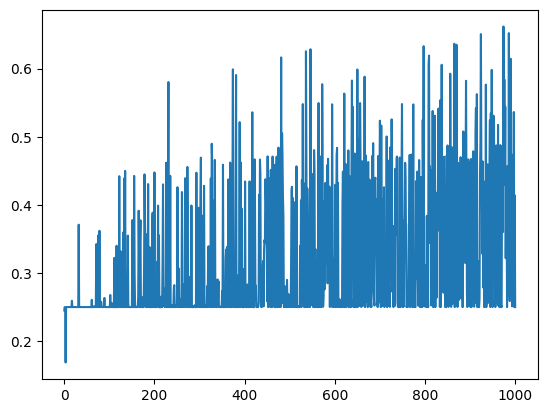

In [25]:
import matplotlib.pyplot as plt
plt.plot(accs_hist)

In [45]:
max(accs_hist)

0.6618421052631579

In [26]:
data_save

[[tensor([[-2.4149e-04,  8.6720e-03,  1.7561e-02,  ..., -1.7449e-02,
            3.0352e-02,  1.1580e-02],
          [ 7.5004e-04,  5.0517e-02,  3.2818e-02,  ..., -3.0193e-02,
            1.5898e-02,  2.3856e-03],
          [-3.1548e-03,  4.2814e-02,  2.4457e-02,  ..., -4.5071e-02,
            1.4155e-02, -7.1915e-03],
          ...,
          [-7.3804e-03,  5.1035e-02, -1.7651e+00,  ...,  6.8607e-01,
           -2.1629e-01, -7.9580e-01],
          [-3.1128e-01,  1.8558e+00,  5.5186e-01,  ..., -9.2133e-01,
            1.6386e+00, -2.7043e-01],
          [ 9.4125e-01, -1.3249e-01,  2.4967e-01,  ..., -5.0045e-01,
           -2.1773e+00,  6.3376e-01]]),
  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 

In [49]:
model = CNNModel().to(device)
evaluate_syn(model, synthetic_text_data, synthetic_labels, test_loader, device, num_epochs=10, lr=0.001)

Training Epoch 10/10: 100%|███████████████████| 4/4 [00:00<00:00, 215.76batch/s]


Epoch [10/10], Train Loss: 3.1837, Train Accuracy: 52.50%


Evaluating on test set: 100%|██████████████| 119/119 [00:07<00:00, 15.45batch/s]

Test Accuracy: 0.4276
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1900
           1       0.36      1.00      0.53      1900
           2       0.59      0.71      0.65      1900
           3       0.00      0.00      0.00      1900

    accuracy                           0.43      7600
   macro avg       0.24      0.43      0.29      7600
weighted avg       0.24      0.43      0.29      7600

[2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 3, 1, 1, 0, 3, 0, 1, 0, 1, 0, 3, 2, 3, 0, 0, 2, 2, 1, 1, 1, 3, 0, 3, 0, 0, 1, 0, 3, 3, 3, 0, 3, 1, 0, 1, 0, 0, 0, 1, 2, 2, 0, 0, 2, 0, 0, 3, 0, 2, 3, 2, 1, 1, 1, 2, 0, 2, 1, 2, 3, 2, 0, 1, 0, 1, 0, 3, 2, 3, 3, 3, 3, 1, 3, 3, 2, 1, 0, 1, 3, 0, 3, 2, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 2, 1, 1, 1, 0, 1, 0, 0, 0, 2, 1, 1, 0, 1, 2, 3, 0, 0, 2, 2, 2, 1, 0, 3, 3, 2, 


/home/IAIS/rrao/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/IAIS/rrao/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/IAIS/rrao/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [62]:
model = CNNModel().to(device)
evaluate_syn(model, synthetic_text_data, synthetic_labels, test_loader, device, num_epochs=300, lr=0.001)

Training Epoch 10/300: 100%|██████████████████| 4/4 [00:00<00:00, 239.93batch/s]


Epoch [10/300], Train Loss: 3.5345, Train Accuracy: 53.50%


Evaluating on test set: 100%|██████████████| 119/119 [00:07<00:00, 15.07batch/s]

Test Accuracy: 0.6704
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.86      0.81      1900
           1       0.77      0.95      0.85      1900
           2       0.53      0.87      0.66      1900
           3       0.00      0.00      0.00      1900

    accuracy                           0.67      7600
   macro avg       0.52      0.67      0.58      7600
weighted avg       0.52      0.67      0.58      7600

[2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 3, 1, 1, 0, 3, 0, 1, 0, 1, 0, 3, 2, 3, 0, 0, 2, 2, 1, 1, 1, 3, 0, 3, 0, 0, 1, 0, 3, 3, 3, 0, 3, 1, 0, 1, 0, 0, 0, 1, 2, 2, 0, 0, 2, 0, 0, 3, 0, 2, 3, 2, 1, 1, 1, 2, 0, 2, 1, 2, 3, 2, 0, 1, 0, 1, 0, 3, 2, 3, 3, 3, 3, 1, 3, 3, 2, 1, 0, 1, 3, 0, 3, 2, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 2, 1, 1, 1, 0, 1, 0, 0, 0, 2, 1, 1, 0, 1, 2, 3, 0, 0, 2, 2, 2, 1, 0, 3, 3, 2, 


/home/IAIS/rrao/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/IAIS/rrao/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/IAIS/rrao/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [29]:
synthetic_text_data.shape

torch.Size([800, 300])

In [34]:
model = CNNModel().to(device)
num_epochs = 100
lr = 0.001

criterion = torch.nn.CrossEntropyLoss()
optimizer_net = optim.Adam(model.parameters(), lr=lr)

# Create DataLoader for synthetic data
synthetic_dataset = data.TensorDataset(synthetic_text_data.detach(), synthetic_labels)
synthetic_loader = data.DataLoader(synthetic_dataset, batch_size=64, shuffle=True)

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for inputs, labels in tqdm(synthetic_loader, desc=f'Training Epoch {epoch+1}/{num_epochs}', unit='batch'):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_net.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_net.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    if epoch % 10  == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')

# Final evaluation on test set
model.eval()
test_labels = []
test_preds = []
with torch.no_grad():
    for texts, labels in tqdm(test_loader, desc='Evaluating on test set', unit='batch'):
        texts, labels = texts.to(device), labels.to(device)
        outputs = model(texts)
        _, preds = torch.max(outputs, 1)
        test_labels.extend(labels.cpu().numpy())
        test_preds.extend(preds.cpu().numpy())

overall_accuracy = accuracy_score(test_labels, test_preds)
class_report = classification_report(test_labels, test_preds, target_names=['0','1','2','3'])

print(f'Test Accuracy: {overall_accuracy:.4f}')
print('Classification Report:')
print(class_report)


Training Epoch 1/100: 100%|█████████████████| 13/13 [00:00<00:00, 196.90batch/s]


Epoch [1/100], Train Loss: 20.2214, Train Accuracy: 38.25%


Training Epoch 11/100: 100%|████████████████| 13/13 [00:00<00:00, 284.78batch/s]


Epoch [11/100], Train Loss: 12.5681, Train Accuracy: 54.38%


Training Epoch 21/100: 100%|████████████████| 13/13 [00:00<00:00, 286.04batch/s]


Epoch [21/100], Train Loss: 10.2487, Train Accuracy: 78.25%


Training Epoch 31/100: 100%|████████████████| 13/13 [00:00<00:00, 312.40batch/s]


Epoch [31/100], Train Loss: 8.5131, Train Accuracy: 75.12%


Training Epoch 41/100: 100%|████████████████| 13/13 [00:00<00:00, 278.80batch/s]


Epoch [41/100], Train Loss: 6.0841, Train Accuracy: 93.38%


Training Epoch 51/100: 100%|████████████████| 13/13 [00:00<00:00, 298.72batch/s]


Epoch [51/100], Train Loss: 4.2228, Train Accuracy: 95.88%


Training Epoch 61/100: 100%|████████████████| 13/13 [00:00<00:00, 291.04batch/s]


Epoch [61/100], Train Loss: 2.9490, Train Accuracy: 97.38%


Training Epoch 71/100: 100%|████████████████| 13/13 [00:00<00:00, 297.88batch/s]


Epoch [71/100], Train Loss: 2.0306, Train Accuracy: 98.50%


Training Epoch 81/100: 100%|████████████████| 13/13 [00:00<00:00, 295.86batch/s]


Epoch [81/100], Train Loss: 1.4328, Train Accuracy: 99.75%


Training Epoch 91/100: 100%|████████████████| 13/13 [00:00<00:00, 304.61batch/s]


Epoch [91/100], Train Loss: 1.0786, Train Accuracy: 99.88%


Evaluating on test set: 100%|██████████████| 119/119 [00:07<00:00, 15.46batch/s]

Test Accuracy: 0.5946
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.91      0.62      1900
           1       0.72      0.93      0.81      1900
           2       0.71      0.43      0.54      1900
           3       0.61      0.11      0.18      1900

    accuracy                           0.59      7600
   macro avg       0.63      0.59      0.54      7600
weighted avg       0.63      0.59      0.54      7600



In [40]:
model = CNNModel().to(device)
num_epochs = 100
lr = 0.001

criterion = torch.nn.CrossEntropyLoss()
optimizer_net = optim.Adam(model.parameters(), lr=lr)

# Create DataLoader for synthetic data
synthetic_dataset = data.TensorDataset(synthetic_text_data.detach(), synthetic_labels)
synthetic_loader = data.DataLoader(synthetic_dataset, batch_size=64, shuffle=True)

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for inputs, labels in tqdm(synthetic_loader, desc=f'Training Epoch {epoch+1}/{num_epochs}', unit='batch'):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_net.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_net.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    if epoch % 10  == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')

# Final evaluation on test set
model.eval()
test_labels = []
test_preds = []
with torch.no_grad():
    for texts, labels in tqdm(test_loader, desc='Evaluating on test set', unit='batch'):
        texts, labels = texts.to(device), labels.to(device)
        outputs = model(texts)
        _, preds = torch.max(outputs, 1)
        test_labels.extend(labels.cpu().numpy())
        test_preds.extend(preds.cpu().numpy())

overall_accuracy = accuracy_score(test_labels, test_preds)
class_report = classification_report(test_labels, test_preds, target_names=['0','1','2','3'])

print(f'Test Accuracy: {overall_accuracy:.4f}')
print('Classification Report:')
print(class_report)


Training Epoch 1/100: 100%|█████████████████| 13/13 [00:00<00:00, 200.19batch/s]


Epoch [1/100], Train Loss: 15.7571, Train Accuracy: 41.25%


Training Epoch 11/100: 100%|████████████████| 13/13 [00:00<00:00, 250.51batch/s]


Epoch [11/100], Train Loss: 11.3243, Train Accuracy: 66.12%


Training Epoch 21/100: 100%|████████████████| 13/13 [00:00<00:00, 258.73batch/s]


Epoch [21/100], Train Loss: 9.5165, Train Accuracy: 79.88%


Training Epoch 31/100: 100%|████████████████| 13/13 [00:00<00:00, 296.45batch/s]


Epoch [31/100], Train Loss: 6.7768, Train Accuracy: 93.62%


Training Epoch 41/100: 100%|████████████████| 13/13 [00:00<00:00, 291.63batch/s]


Epoch [41/100], Train Loss: 4.8495, Train Accuracy: 95.75%


Training Epoch 51/100: 100%|████████████████| 13/13 [00:00<00:00, 277.67batch/s]


Epoch [51/100], Train Loss: 3.1626, Train Accuracy: 96.88%


Training Epoch 61/100: 100%|████████████████| 13/13 [00:00<00:00, 293.71batch/s]


Epoch [61/100], Train Loss: 2.0838, Train Accuracy: 98.38%


Training Epoch 71/100: 100%|████████████████| 13/13 [00:00<00:00, 275.94batch/s]


Epoch [71/100], Train Loss: 1.5214, Train Accuracy: 99.62%


Training Epoch 81/100: 100%|████████████████| 13/13 [00:00<00:00, 285.35batch/s]


Epoch [81/100], Train Loss: 1.1939, Train Accuracy: 99.38%


Training Epoch 91/100: 100%|████████████████| 13/13 [00:00<00:00, 240.74batch/s]


Epoch [91/100], Train Loss: 0.7912, Train Accuracy: 100.00%


Evaluating on test set: 100%|██████████████| 119/119 [00:07<00:00, 15.27batch/s]

Test Accuracy: 0.6018
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.90      0.63      1900
           1       0.75      0.91      0.82      1900
           2       0.70      0.41      0.52      1900
           3       0.52      0.19      0.28      1900

    accuracy                           0.60      7600
   macro avg       0.62      0.60      0.56      7600
weighted avg       0.62      0.60      0.56      7600



In [39]:
texts.shape

torch.Size([48, 300])

In [41]:
model = CNNModel().to(device)
num_epochs = 150
lr = 0.001

criterion = torch.nn.CrossEntropyLoss()
optimizer_net = optim.Adam(model.parameters(), lr=lr)

# Create DataLoader for synthetic data
synthetic_dataset = data.TensorDataset(synthetic_text_data.detach(), synthetic_labels)
synthetic_loader = data.DataLoader(synthetic_dataset, batch_size=64, shuffle=True)

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for inputs, labels in tqdm(synthetic_loader, desc=f'Training Epoch {epoch+1}/{num_epochs}', unit='batch'):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_net.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_net.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    if epoch % 10  == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')

# Final evaluation on test set
model.eval()
test_labels = []
test_preds = []
with torch.no_grad():
    for texts, labels in tqdm(test_loader, desc='Evaluating on test set', unit='batch'):
        texts, labels = texts.to(device), labels.to(device)
        outputs = model(texts)
        _, preds = torch.max(outputs, 1)
        test_labels.extend(labels.cpu().numpy())
        test_preds.extend(preds.cpu().numpy())

overall_accuracy = accuracy_score(test_labels, test_preds)
class_report = classification_report(test_labels, test_preds, target_names=['0','1','2','3'])

print(f'Test Accuracy: {overall_accuracy:.4f}')
print('Classification Report:')
print(class_report)


Training Epoch 1/150: 100%|█████████████████| 13/13 [00:00<00:00, 198.82batch/s]


Epoch [1/150], Train Loss: 18.5240, Train Accuracy: 39.62%


Training Epoch 11/150: 100%|████████████████| 13/13 [00:00<00:00, 295.04batch/s]


Epoch [11/150], Train Loss: 11.9248, Train Accuracy: 55.88%


Training Epoch 21/150: 100%|████████████████| 13/13 [00:00<00:00, 289.00batch/s]


Epoch [21/150], Train Loss: 10.5003, Train Accuracy: 64.62%


Training Epoch 31/150: 100%|████████████████| 13/13 [00:00<00:00, 315.66batch/s]


Epoch [31/150], Train Loss: 7.4847, Train Accuracy: 91.50%


Training Epoch 41/150: 100%|████████████████| 13/13 [00:00<00:00, 300.27batch/s]


Epoch [41/150], Train Loss: 5.3367, Train Accuracy: 94.75%


Training Epoch 51/150: 100%|████████████████| 13/13 [00:00<00:00, 240.02batch/s]


Epoch [51/150], Train Loss: 3.5916, Train Accuracy: 96.38%


Training Epoch 61/150: 100%|████████████████| 13/13 [00:00<00:00, 226.51batch/s]


Epoch [61/150], Train Loss: 2.5322, Train Accuracy: 97.38%


Training Epoch 71/150: 100%|████████████████| 13/13 [00:00<00:00, 247.52batch/s]


Epoch [71/150], Train Loss: 2.2041, Train Accuracy: 98.00%


Training Epoch 81/150: 100%|████████████████| 13/13 [00:00<00:00, 257.13batch/s]


Epoch [81/150], Train Loss: 1.3835, Train Accuracy: 99.75%


Training Epoch 91/150: 100%|████████████████| 13/13 [00:00<00:00, 250.60batch/s]


Epoch [91/150], Train Loss: 1.0286, Train Accuracy: 99.75%


Training Epoch 101/150: 100%|███████████████| 13/13 [00:00<00:00, 226.63batch/s]


Epoch [101/150], Train Loss: 0.8323, Train Accuracy: 100.00%


Training Epoch 111/150: 100%|███████████████| 13/13 [00:00<00:00, 254.72batch/s]


Epoch [111/150], Train Loss: 0.6435, Train Accuracy: 100.00%


Training Epoch 121/150: 100%|███████████████| 13/13 [00:00<00:00, 258.29batch/s]


Epoch [121/150], Train Loss: 0.5149, Train Accuracy: 100.00%


Training Epoch 131/150: 100%|███████████████| 13/13 [00:00<00:00, 264.79batch/s]


Epoch [131/150], Train Loss: 0.4220, Train Accuracy: 100.00%


Training Epoch 141/150: 100%|███████████████| 13/13 [00:00<00:00, 257.10batch/s]


Epoch [141/150], Train Loss: 0.3463, Train Accuracy: 100.00%


Evaluating on test set: 100%|██████████████| 119/119 [00:07<00:00, 15.22batch/s]

Test Accuracy: 0.6153
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.87      0.65      1900
           1       0.74      0.89      0.81      1900
           2       0.71      0.43      0.53      1900
           3       0.50      0.27      0.35      1900

    accuracy                           0.62      7600
   macro avg       0.62      0.62      0.59      7600
weighted avg       0.62      0.62      0.59      7600



In [47]:
len(test_labels)

7600